# Simulation of molecular motor dynamics on microtubules


### Work done by:
* Simulation code: Maurits Kok
* Experiments and theory: Louis Reese



### Abstract
The precise localization of proteins is key to understand biological functions and to quantify protein interactions. Microtubule related motor proteins consume ATP to move along microtubules and often localize at microtubule tips. Whereas molecular motors have been studied extensively in terms of run-lengths and dwell times on the single molecule level, a quantitative understanding of the accumulation of motors on microtubules is still lacking. Here we develop a high-throughput microscopy strategy to accurately determine the distribution of motors on microtubules. By imaging an ensemble of microtubules with motors, datasets are obtained which allow to quantify parameters of a minimal model for the microtubule-motor system. The approach bypasses typical constraints of fluorescence imaging such as bleaching and small sample sizes. As a proof of principle we study quantitatively study the length-dependent accumulation of motors for the case of a yeast dynein. 


### Simulation
To understand the experimentally measured motor protein profiles, we use a simple Gilliespie algorithm to simulate the motion of yeast dynein on a 1D lattice. Four different event can occur:

Event 1: Attachment of a particle to an empty lattice site with rate $k_{on}$    
Event 2: Detachment of a particle from an occupied lattice site with rate $k_{on}$   
Event 3: Detachment of a particle from the lattice end with rate $k_{on}^{tip}$  
Event 4: Forward hopping (if next lattice position is unoccupied) with rate $k_{hop}$


<img src="Fig_model.png" alt="Drawing" style="width: 1000px;"/>


### Relevant publications:
* Cho et al. (2008). "Regulatory ATPase sites of cytoplasmic dynein affect processivity and force generation". JBC 283(38): 25839-25845
* Leduc et al. (2012). "Molecular crowding creates traffic jams of kinesin motors on microtubules". PNAS 109(16): 6100-6105
* Parmeggiani et al. (2004). "Totally assymetric simple exclusion process with Langmuir kinetics". Phys Rev Lett 70: 046101



In [1]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.gridspec as gridspec
import pandas as pd
import pickle
import sys
import os
from datetime import date, datetime
from time import strftime
from parameters import ParameterSet
from IPython.display import clear_output

## Define simulation parameters
\
The simulation is performed for a single dynein concentration over a range of lattice sizes until a maximum time. 


In [2]:
# Dictionary to store all simulation parameters
simParameters = {}
simParameters['record_data'] = False  # Store data and figures: True or False
simParameters['num_sims'] = 200  # Number of simulations per scan condition 
simParameters['scan'] = False  # True (vary lattice size) or False
simParameters['type'] = 'SP'  # Determine type of dynein: 'WT' (Wild-Type) or 'SP' (Super-Processive)
simParameters['concentration'] = 2.5  # Dynein concentration in nM 
simParameters['step_size'] = 24  # Basic lattice unit is size of motor step, for dynein the step size is 24 nm
simParameters['length'] = 100  # Length lattice in hopping units
simParameters['length_range'] = np.arange(40, 301, 10)  # length range to scan
simParameters['iter_max'] = 100000  # Maximum number of iterations per condition
simParameters['time_max'] = 300  # Max simulated time (in seconds)

# Frame time to sample the lattice configuration (in seconds). 
# If 0, then only the final state will be saved and no kymographs will be generated
simParameters['frame_time'] = 1  

#### Characteristics of yeast dynein
\
The properties for Wild-Type (WT) and Super-Processive (SP) dynein are taken from Cho et al. JCB 2008.

| Dynein | Runlength | Velocity|
| --- | --- | --- |
| Wild type (WT) | 2.25 ± 0.14 $\mu m$ | 73.9 ± 34.2 $nm/sec$ |
| Super processive (SP) | 4.39 ± 0.45 $\mu m$ | 60.6 ± 18.9 $nm/sec$

In [3]:
if simParameters['type'] == 'WT':  # Wild-type dynein
    simParameters['k_on'] = 0.0025  # Attachment rate [/nM/sec]
    simParameters['k_off'] = 73.9/2250  # Detachment rate bulk [/sec]
    simParameters['k_hop'] = 73.9/simParameters['step_size']  # Forward hopping rate [sites/sec]        
    simParameters['k_off_end'] = simParameters['k_off']  # Detachment rate end lattice [/sec]
    
elif simParameters['type'] == 'SP':   # Super processive dynein
    simParameters['k_on'] = 0.0025 #  Attachment rate [/nM/sec]
    simParameters['k_off'] = 60.6/4390  # Detachment rate bulk [/sec]
    simParameters['k_hop'] = 60.6/simParameters['step_size']  # Forward hopping rate [sites/sec]  
    simParameters['k_off_end'] = simParameters['k_off']  # Detachment rate end lattice [/sec]

In [4]:
# Transform parameters into a ParameterSet
simPa = ParameterSet(simParameters)

In [5]:
# Set default folder
ROOT  = os.getcwd() 
sys.path.insert(0, ROOT)

# Setup data recording variables
DATE = str(date.today())
TIME = str(strftime('%X'))
TIME = TIME.replace(':', '-')

# Create output folder
if simPa.record_data:
#     foldername = ROOT + '\\SIM_RUNS\\' + DATE + '__' + TIME
    foldername = 'G:\\DATA\\SIM_RUNS\\' + DATE + '__' + TIME       
    os.makedirs(foldername)

### Function to calculate the propensities of all events  

In [6]:
# Calculate the propensity for each event
def propensity(rates, lattice):
    num_event_1 = np.count_nonzero(lattice == 0)  # Empty sites
    num_event_2 = np.count_nonzero(lattice[:-1] == 1)  # Occupied sites
    num_event_3 = lattice[-1]  # Lattice end
    num_event_4 = np.count_nonzero((lattice[1:] - lattice[:-1]) == -1)  # Foward hopping
    pp = np.multiply(rates, [num_event_1, num_event_2, num_event_3, num_event_4])
        
    return pp  

### Function to update the lattice after an event

In [7]:
# Update state of lattice    
def update_state(event, state):            
    if event == 0:  # Attachment event   
        pos = np.nonzero(state == 0)[0]
        index = np.random.choice(pos)
        state[index] += 1 
    elif event == 1:  # Detachment event lattice
        pos = np.nonzero(state[:-1] == 1)[0]
        index = np.random.choice(pos)
        state[index] -= 1
    elif event == 2:  # Detachment event lattice end
        state[-1] -= 1
    elif event == 3:  # Forward hopping event
        pos = np.nonzero((state[1:] - state[:-1]) == -1)[0]
        index = np.random.choice(pos)
        state[index] -= 1
        state[index + 1] += 1
    
    return state

### Function to run the Gillespie simulation

In [8]:
# Monte Carlo simulation based on the Gillespie algorithm
def gillespie(simPa):                    
    # Extract simulation parameters
    rates = [simPa.concentration*simPa.k_on, simPa.k_off, simPa.k_off_end, simPa.k_hop]

    # Initialize simulation counters and output
    counter = 0  # simulation iteration
    tt = 0  # time
    lattice = np.zeros(simPa.length) # start simulation with an empty lattice
    lattice_cont = []
    tt_cont = []   
    rand_nums = np.random.rand(2,simPa.iter_max)   # Pre-draw random numbers

    # Run Gillespie simulation until "simPa.time_max"
    while simPa.iter_max > counter and simPa.time_max+1 > tt:
                  
        pp = propensity(rates, lattice)  # Calculate probability for all events       
        delta_t = -np.log(rand_nums[0][counter]) / pp.sum()  # Draw waiting time

        # Construct valid events
        valid_inds = pp > 0 # Find the possible events
        valid_pp = pp[valid_inds] # Include only valid events
        valid_changes = np.nonzero(valid_inds)[0]       
        
        # Stop current simulation if no valid changes are available
        if len(valid_changes) == 0:
            break   

        selection_interval = valid_pp.cumsum()  # Construct intervals
        selection_interval = selection_interval/selection_interval[-1]
        selected_ind = np.nonzero(selection_interval > rand_nums[1][counter])[0][0]   # Select interval
        lattice = update_state(valid_changes[selected_ind], lattice)  # Update lattice configuration based on chosen interval
        
        tt += delta_t   
        counter +=1                
        
        # Apply sampling if applicable        
        if simPa.frame_time > 0:
            while len(lattice_cont) < np.floor(tt/simPa.frame_time) and len(lattice_cont) <= simPa.time_max:                   
                lattice_cont.append(lattice.copy())
                tt_cont.append(tt)            
    
    # Collect final state if sampling is off  
    if simPa.frame_time == 0:
        lattice_cont = lattice
        tt_cont = tt
        
    return lattice_cont, tt_cont              

### Simulation of motor protein dynamics on a 1D lattice

The data is stored as a pandas.DataFrame

In [9]:
RESULTS = pd.DataFrame(columns=['Time', 'Lattice','Concentration', 'Length', 'Frametime', 'Type', 'Stepsize', 'Rates', 'Datestamp', 'Timestamp'])
rates = [simPa.concentration*simPa.k_on, simPa.k_off, simPa.k_off_end, simPa.k_hop]
update = 0        

# Setup parameter scanning
if simPa.scan:    
    simPa.scan_range = simPa.length_range
else:
    simPa.scan_range = [simPa.length]
    
for length in simPa.scan_range:    
    simPa.length = length  # Update lattice size     
    for run in range(simPa.num_sims):

        clear_output(wait=True)    
        [lattice, time] = gillespie(simPa)  # Call Gillespie simulation

        # Store results as pandas.DataFrame        
        data = {
                'Time': np.asarray(time), 'Lattice': np.asarray(lattice), 
                'Concentration': simPa.concentration, 'Length': simPa.length, 
                'Frametime': simPa.frame_time, 'Type': simPa.type, 'Stepsize': simPa.step_size,
                'Rates': np.round(rates,4), 'Datestamp': DATE, 'Timestamp': TIME.replace('-', ':')
               }
        RESULTS = RESULTS.append(data, ignore_index=True)                                 

        # Update progress report
        update += 1
        print("Current progress:",np.round(update/(len(simPa.scan_range)*simPa.num_sims) *100, 2),"%")    

Current progress: 100.0 %


In [10]:
# Save Data
if simPa.record_data:            
    filename = foldername + '\\' + 'SIM_DYNEIN_' + str(simPa.type) + '_' + str(simPa.concentration) + '.data'
       
    with open(filename, 'wb') as filehandle:
        pickle.dump(RESULTS, filehandle)    

### Display kymograph for all lattice lengths

Only possibile if the lattice is sampled over time, i.e. frame time > 0.

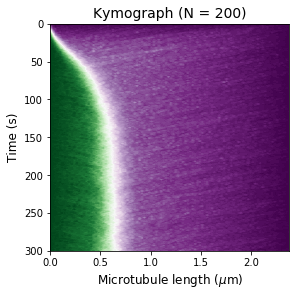

In [11]:
# Plot kymographs if time-series is present, i.e. frame time > 0
if simPa.frame_time > 0:
    # Number of plots
    if simPa.scan:
        num_scans = len(simPa.scan_range)
        rows = int(np.ceil(num_scans/3))
        cols = num_scans if num_scans < 3 else 3 
    else:
         rows = cols = 1

    # Setup figure
    fig = plt.figure(constrained_layout=True, figsize=(cols*4 ,rows*4))
    spec = fig.add_gridspec(ncols=cols, nrows=rows)

    fig_num = 0
    for row in range(rows):
        for col in range(cols):         
            if fig_num < len(simPa.scan_range):

                # Filter specific lattice size
                filter_length = RESULTS['Length']==simPa.scan_range[fig_num]
                lattice = RESULTS[filter_length].Lattice           

                # Prepare data
                X = np.arange(0, lattice.iloc[0].shape[1])
                X = X * (simPa.step_size/1000) # change units to um
                Y = np.arange(0, lattice.iloc[0].shape[0])
                Y = Y * simPa.frame_time # change units to seconds
                X, Y = np.meshgrid(X, Y)      
                Z_mean = np.mean(lattice, axis=0)                      

                # Plot data
                ax = fig.add_subplot(spec[row, col])     
                ax.contourf(np.flip(X), Y, Z_mean, 100, cmap='PRGn')    
                ax.set_ylim(Y[-1][0],0)  
                ax.set_xlabel('Microtubule length ($\mu$m)', fontsize=12)
                ax.set_ylabel('Time (s)', fontsize=12)

                if simPa.scan:
                    ax.set_title('Length = ' + str(np.round(simPa.scan_range[fig_num]*(simPa.step_size/1000),2)) + ' $\mu$m' , fontsize=14)  
                else:
                    ax.set_title('Kymograph (N = ' + str(simPa.num_sims) + ')', fontsize=14)

                fig_num += 1

    # Save plot
    if simPa.record_data:
        filename = foldername + "/" + 'Figure_1'
        plt.savefig(filename+'.eps', format='eps', dpi=1200)
        plt.savefig(filename+'.png', format='png', dpi=300)

    plt.show()